# Ejercicio: ANOVA y medidas de dispersión

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Mayo de 2025

**Versión:** 1.0  

---

## Descripción

Este notebook contiene un ejercicio donde calculan medidas de dispersión y se aplica análisis de varianza (ANOVA).

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (2.2.2
- numpy (2.02)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

# Contexto

Una asignatura probó tres métodos de enseñanza — *Tradicional*, *Flipped* y *Online*. Se midieron las horas de estudio y el **puntaje final** (0–100). Se desea comparar si el **promedio de puntaje** difiere entre métodos.

**Archivo de datos:** `datos_anova_estudiantes.csv` (columnas: `id`, `metodo`, `horas_estudio`, `sede`, `puntaje`).

---

## Objetivos
1. Explorar el dataset y calcular **medidas de dispersión** por método (rango, varianza, desviación estándar y CV).
2. Visualizar la distribución de `puntaje` por `metodo` (boxplots).
3. Verificar supuestos del ANOVA (normalidad por grupo y homogeneidad de varianzas).
4. Aplicar **ANOVA de un factor** para comparar las medias de `puntaje` entre métodos.
5. Si el ANOVA es significativo, realizar **comparaciones post-hoc** (Tukey HSD).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats

from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Descargar el archivo y guardarlo en el entorno
!wget https://raw.githubusercontent.com/JaznaLaProfe/Fundamentos-de-Machine-Learning/master/data/datos_anova_estudiantes.csv

--2025-08-16 21:08:00--  https://raw.githubusercontent.com/JaznaLaProfe/Fundamentos-de-Machine-Learning/master/data/datos_anova_estudiantes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13534 (13K) [text/plain]
Saving to: ‘datos_anova_estudiantes.csv’

datos_anova_estudia 100%[===================>]  13.22K  --.-KB/s    in 0s      

2025-08-16 21:08:00 (34.8 MB/s) - ‘datos_anova_estudiantes.csv’ saved [13534/13534]



In [3]:
data = pd.read_csv("datos_anova_estudiantes.csv")
data.head()

,id,metodo,horas_estudio,sede,puntaje
0,T001,Tradicional,2.631496,Centro,82.147095
1,T002,Tradicional,4.297876,Norte,67.927349
2,T003,Tradicional,3.726383,Sur,86.268726
3,T004,Tradicional,2.294964,Norte,78.294437
4,T005,Tradicional,3.037120,Centro,69.911631


In [4]:
def medidas_dispersion(datos : np.array):
  data = np.asarray(datos, dtype=float)
  rango = np.max(data) - np.min(data)
  var_muestral = np.var(data, ddof=1)
  desvest = np.std(data, ddof=1)
  cv = (desvest / np.mean(data)) * 100
  return pd.Series({
        "n": len(data),
        "Media": np.mean(data),
        "Rango": rango,
        "Varianza": var_muestral,
        "Desviación Estándar": desvest,
        "Coeficiente de Variación (%)": cv
    })

In [5]:
tabla_disp = data.groupby("metodo")["puntaje"].apply(medidas_dispersion)
tabla_disp

metodo                                   
Flipped      n                               80.000000
             Media                           77.237565
             Rango                           30.064118
             Varianza                        40.913453
             Desviación Estándar              6.396362
             Coeficiente de Variación (%)     8.281414
Online       n                               80.000000
             Media                           82.073774
             Rango                           47.801808
             Varianza                        84.298157
             Desviación Estándar              9.181403
             Coeficiente de Variación (%)    11.186768
Tradicional  n                               80.000000
             Media                           73.314553
             Rango                           37.557807
             Varianza                        68.022574
             Desviación Estándar              8.247580
             Coeficiente de Variación (%)    11.249581
Name: puntaje, dtype: float64

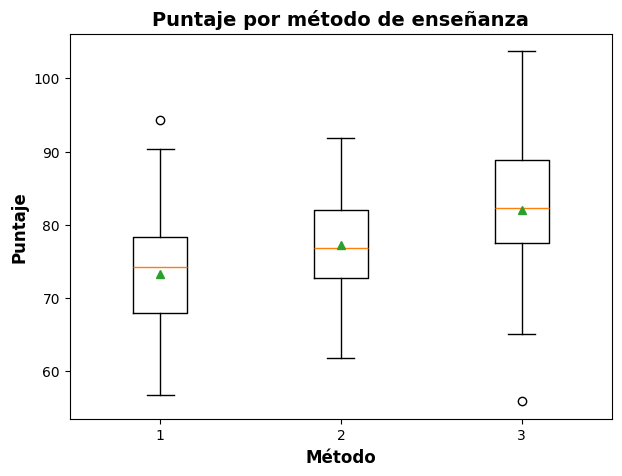

In [8]:
orden = data["metodo"].unique().tolist()
datos = [data.loc[data["metodo"]==m, "puntaje"].values for m in orden]

plt.figure(figsize=(7,5))
plt.boxplot(datos, showmeans=True)
plt.title("Puntaje por método de enseñanza", fontsize=14, fontweight="bold")
plt.xlabel("Método", fontsize=12, fontweight="bold")
plt.ylabel("Puntaje", fontsize=12, fontweight="bold")
plt.show()

# Shapiro-Wilk

+ Se trata de una prueba estadística utilizada para verificar si una muestra de datos proviene de una distriución normal.

+ Calcula un estadístico llamada ***W*** que compara la muestra con una distribución normal teórica. Un valor cercano a 1 indica una mayor similitud con la normalidad y valores más bajos indican una desviación de la distribución normal.

+ Es bastante útil porque varios métodos estadísticos (como la prueba *t* y ANOVA) asumen que los datos siguen una distribución normal y si esta suposición no se cumple entonces los resultados de estas pruebas podrían ser inválidos.

**¿Cómo se interpreta?**

+ Hipótesis nula ($H_0$): la muestra proviene de una población con distribución normal.

+ Hipótesis alternativa ($H_1$): la muestra no proviene de una población con distribución normal.

El resultado de la prueba se expresa como un valor *p*. Si el valor de *p* es menor a un nivel de significancia (normalmente 0.05) se rechaza la hipótesis nula indicando que los datos no son normales.

**Consideraciones**

+ Especialmente recomendada para muestras pequeñas (n < 50).
+ Es una prueba útil, su precisión puede disminuir con muestras muy grandes.
+ Es recomendable combinar con gráficos QQ plot para evaluación visual de la normalidad.

In [16]:
# Normalidad por grupo (Shapiro-Wilk)
for m in data["metodo"].unique():
  valores = data.loc[data["metodo"]==m, "puntaje"].values
  stat, p = stats.shapiro(valores)
  print(f"Shapiro {m}: W={stat:.3f}, p={p:.4f}")

Shapiro Tradicional: W=0.990, p=0.8077
Shapiro Flipped: W=0.992, p=0.9268
Shapiro Online: W=0.986, p=0.5600


In [21]:
def view_QQ_plot(data : pd.DataFrame, target : str):
  fig = sm.qqplot(data.loc[data["metodo"]==target, "puntaje"].values, line='s')
  plt.title(f"Q-Q Plot de método '{target}'", fontsize=14, fontweight="bold")
  plt.show()

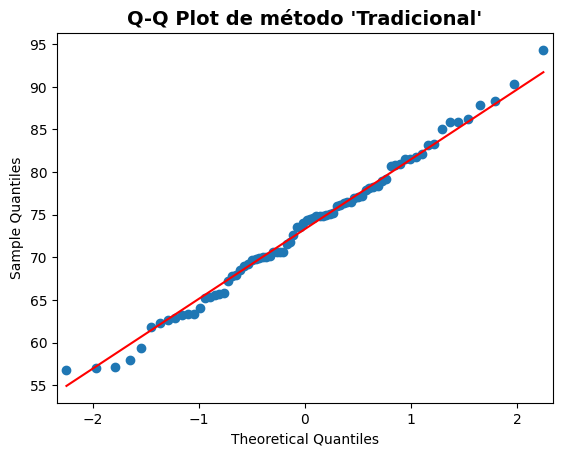

In [22]:
view_QQ_plot(data, "Tradicional")

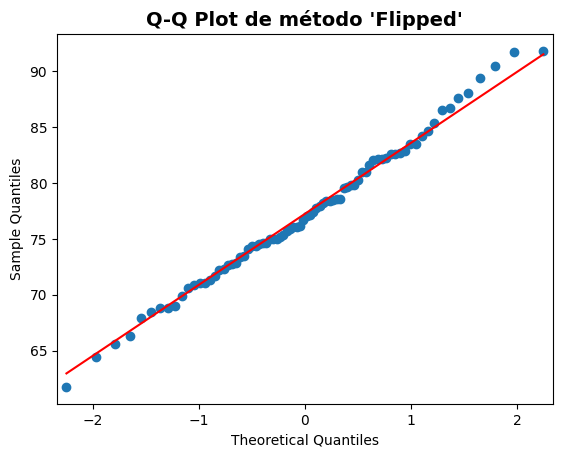

In [23]:
view_QQ_plot(data, "Flipped")

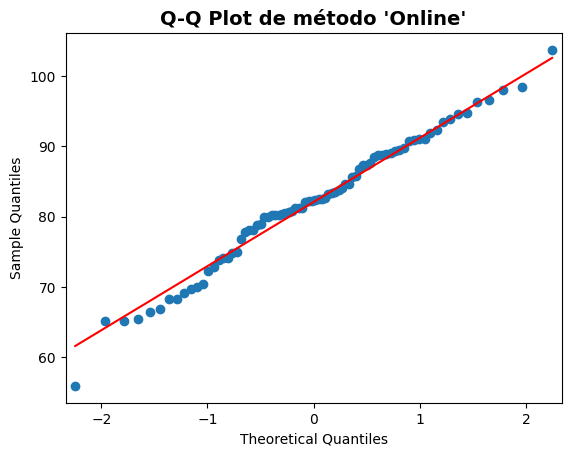

In [24]:
view_QQ_plot(data, "Online")

In [27]:
grupos = [data.loc[data["metodo"]==m, "puntaje"].values for m in data["metodo"].unique()]
f_stat, p_val = stats.f_oneway(*grupos)
print(f"ANOVA: F={f_stat:.3f}, p={p_val:.6f}")

ANOVA: F=23.909, p=0.000000


# Prueba Tukey HSD

+ **Tukey HSD (Honest Significant Difference)** es un conocido método estadístico utilizado para realizar comparaciones múltiples entre medias de grupos, especialmente después de realizar un análisis de varianza (ANOVA).

+ Su objetivo es determinar qué grupos difieren significativamente entre si.

In [28]:
tukey = pairwise_tukeyhsd(endog=data["puntaje"], groups=data["metodo"], alpha=0.05)
print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2   meandiff p-adj   lower    upper  reject
-----------------------------------------------------------
Flipped      Online   4.8362 0.0005   1.8433  7.8291   True
Flipped Tradicional   -3.923 0.0063  -6.9159 -0.9301   True
 Online Tradicional  -8.7592    0.0 -11.7521 -5.7663   True
-----------------------------------------------------------


# Conclusión (para completar)
- ¿Se rechazó H₀? (p < 0.05)
- ¿Qué pares difieren según Tukey?
- ¿Cuál es el método con mayor media y cómo se ve su variabilidad (CV)?